# Multi-class Classification - Predict the Poker Hand

Dataset:
https://archive.ics.uci.edu/ml/datasets/Poker+Hand

## Dataset observations

https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand.names

- 10 classes
- 1 million test samples
- missing values: None
- classes are not balanced (some poker hands are rare)
- separate test dataset from train dataset

## Workflow

Data Gathering
1. read_csv for both training and test set

Data Transformation
2. transform dataframe
3. PCA to plot (for classification)
4. shuffle training set (train test split not necessary as there is a separate test set)
5. (scaling is optional because the column values are all similar)

Training
6. Train a Logistic Regression model
7. Train a Logistic Regression model with SGD

Validation
8. metrics
9. learning curve
10. predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

## Data Gathering (Estimated time: 15 min)

1. read_csv for both training and test set

In [83]:
clm_names = ['SuitOfCard1', 'RankOfCard1', 'SuitOfCard2','RankOfCard2', 'SuitOfCard3', 'RankOfCard3', 'SuitOfCard4', 'RankOfCard4', 'SuitOfCard5', 'RankOfCard5','CardClass']
df_training = pd.read_csv("C:\\courses\\data\\poker-hand\\poker-hand-training-true.data",names=clm_names)
df_training.shape

(25010, 11)

In [20]:
df_training.SuitOfCard1.head()

0    1
1    2
2    3
3    4
4    4
Name: SuitOfCard1, dtype: int64

In [52]:
df_testing = pd.read_csv("C:\\courses\\data\\poker-hand\\poker-hand-testing.data",names=clm_names)
df_testing.head()

SuitOfCard1  RankOfCard1  SuitOfCard2  RankOfCard2  SuitOfCard3  \
0            1            1            1           13            2   
1            3           12            3            2            3   
2            1            9            4            6            1   
3            1            4            3           13            2   
4            3           10            2            7            1   

   RankOfCard3  SuitOfCard4  RankOfCard4  SuitOfCard5  RankOfCard5  CardClass  
0            4            2            3            1           12          0  
1           11            4            5            2            5          1  
2            4            3            2            3            9          1  
3           13            2            1            3            6          1  
4            2            2           11            4            9          0

## Data Transformation (Estimated time: 30 min)
2. transform dataframe
3. PCA to plot (for classification)
4. shuffle training set (train test split not necessary as there is a separate test set)
5. (scaling is optional because the column values are all similar)

```
# How to shuffle a pandas DataFrame
df_shuffled = df.sample(frac=1)
```

In [48]:
df_training.SuitOfCard1.unique()

array([1, 2, 3, 4], dtype=int64)

In [39]:
pd.get_dummies(df_training.RankOfCard1).head()

1   2   3   4   5   6   7   8   9   10  11  12  13
0   0   0   0   0   0   0   0   0   0   1   0   0   0
1   0   0   0   0   0   0   0   0   0   0   1   0   0
2   0   0   0   0   0   0   0   0   0   0   0   1   0
3   0   0   0   0   0   0   0   0   0   1   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0   0   0

In [43]:
columns_to_encode = clm_names[0:10]
print(columns_to_encode)


np.testing.assert_array_equal(columns_to_encode, df_training.loc[:, columns_to_encode].columns)
#df_training.loc[:, columns_to_encode]
dummies = pd.get_dummies(df_training.loc[:, columns_to_encode])
dummies.columns

['SuitOfCard1', 'RankOfCard1', 'SuitOfCard2', 'RankOfCard2', 'SuitOfCard3', 'RankOfCard3', 'SuitOfCard4', 'RankOfCard4', 'SuitOfCard5', 'RankOfCard5']


Index(['SuitOfCard1', 'RankOfCard1', 'SuitOfCard2', 'RankOfCard2',
       'SuitOfCard3', 'RankOfCard3', 'SuitOfCard4', 'RankOfCard4',
       'SuitOfCard5', 'RankOfCard5'],
      dtype='object')

In [60]:
X = df_training.loc[:,'SuitOfCard1':'RankOfCard5']

In [61]:
X = df_training.loc[:,clm_names[0:10]]
y = df_training.CardClass

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

print(X.shape, X_2d.shape)

(25010, 10) (25010, 2)


In [81]:
# 0: Nothing in hand; not a recognized poker hand 
# 1: One pair; one pair of equal ranks within five cards
# 2: Two pairs; two pairs of equal ranks within five cards
# 3: Three of a kind; three equal ranks within five cards
# 4: Straight; five cards, sequentially ranked with no gaps
# 5: Flush; five cards with the same suit
# 6: Full house; pair + different rank three of a kind
# 7: Four of a kind; four equal ranks within five cards
# 8: Straight flush; straight + flush
# 9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

labels = np.array([[0, 'nothing'], [1, 'one pair'],
          [2, 'two pair'], [3, '3 of a kind'],
          [4, 'straight'], [5, 'flush'],
          [6, 'full house'], [7, '4 of a kind'],
          [8, 'straight flush'], [9, 'royal flush']])


X_train = df_training.loc[:,clm_names[0:10]]
y_train = df_training.CardClass

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

fig, ax = plt.subplots(figsize=(15, 10))
for value in y_train.unique():    
    ax.scatter(X_train_2d[y_train==value][:, 0],
               X_train_2d[y_train==value][:, 1],
               label=labels[value, 1],
               cmap=plt.cm.plasma)
ax.legend()
plt.show()

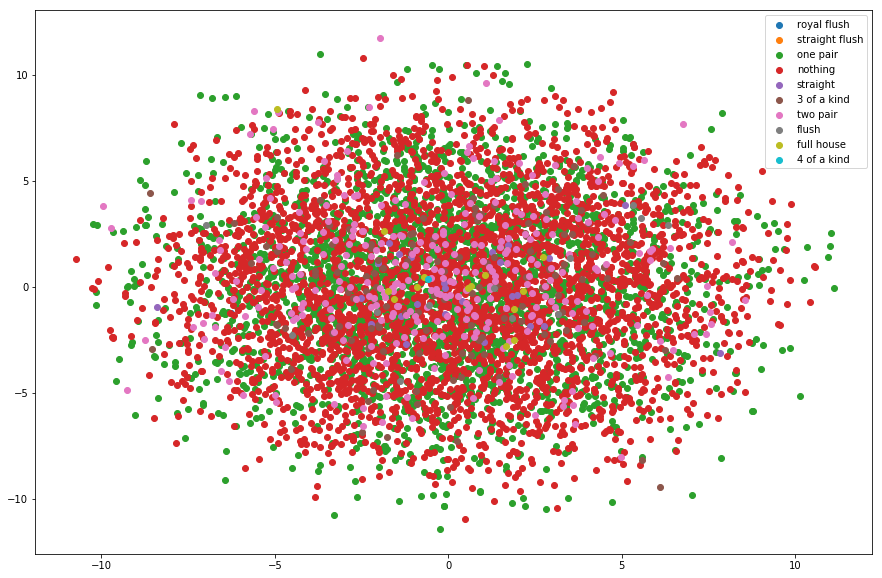

In [72]:
# plot a subset of samples
density = .25
df_subset = df_training.sample(frac=density, random_state=42)

X_train_subset = df_subset.loc[:,clm_names[0:10]]
y_train_subset = df_subset.CardClass

pca = PCA(n_components=2)
X_train_subset_2d = pca.fit_transform(X_train_subset)

fig, ax = plt.subplots(figsize=(15, 10))
for value in y_train.unique():    
    ax.scatter(X_train_subset_2d[y_train_subset==value][:, 0],
               X_train_subset_2d[y_train_subset==value][:, 1],
               label=labels[value, 1],
               cmap=plt.cm.plasma)
ax.legend()
plt.show()

In [71]:
#for value in y_train.unique():
# for value in [9, 8, 1, 0, 4, 3, 2, 5, 6, 7]:
for value in [9, 8]:
    ax.scatter(X_train_2d[y_train==value][:, 0],
               X_train_2d[y_train==value][:, 1],
               label=labels[value, 1],
               cmap=plt.cm.plasma)

In [74]:
# plot a subset of samples
density = .25
df_subset = df_training.sample(frac=density, random_state=42)

X_train_subset = df_subset.loc[:, clm_names[0:10]]
y_train_subset = df_subset.loc[:, 'CardClass']

pca = PCA(n_components=1)
X_train_subset_1d = pca.fit_transform(X_train_subset)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_train_subset_1d, y_train_subset)
ax.legend()
ax.set_title('1D PCA')
plt.show()

In [75]:
# How to shuffle a pandas DataFrame
df_shuffled = df_training.sample(frac=1)

X_train = df_shuffled.loc[:, clm_names[0:10]]
y_train = df_shuffled.loc[:, 'CardClass']

## Training (Estimated time: 30 min)
6. Train a Logistic Regression model
7. Train a Logistic Regression model with SGD

In [82]:
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)

pred = logistic.predict(X_train)

cm = confusion_matrix(y_train, pred)
print(cm)
print(X_train.shape)
print(classification_report(y_train,pred))

[[12493     0     0     0     0     0     0     0     0     0]
 [10599     0     0     0     0     0     0     0     0     0]
 [ 1206     0     0     0     0     0     0     0     0     0]
 [  513     0     0     0     0     0     0     0     0     0]
 [   93     0     0     0     0     0     0     0     0     0]
 [   54     0     0     0     0     0     0     0     0     0]
 [   36     0     0     0     0     0     0     0     0     0]
 [    6     0     0     0     0     0     0     0     0     0]
 [    5     0     0     0     0     0     0     0     0     0]
 [    5     0     0     0     0     0     0     0     0     0]]
(25010, 10)
             precision    recall  f1-score   support

          0       0.50      1.00      0.67     12493
          1       0.00      0.00      0.00     10599
          2       0.00      0.00      0.00      1206
          3       0.00      0.00      0.00       513
          4       0.00      0.00      0.00        93
          5       0.00      0.00      

C:\Users\prith\AppData\Local\Continuum\anaconda3\envs\mldds02\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
sgd = SGDClassifier(random_state=42, tol=1e-3, max_iter=1000)

sgd.fit(X_train, y_train)

pred_sgd = sgd.predict(X_train)
pred_sgd

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

[Text(0,0.5,'Denied'), Text(0,1.5,'Approved')]

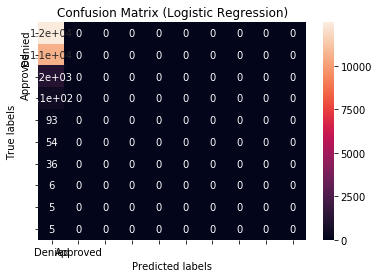

In [79]:
# matplotlib can plot confusion matrices, isn't as easy as seaborn

# conda install -y seaborn

import seaborn as sns

fig, ax = plt.subplots()

# annotate cells with ticks
sns.heatmap(cm, annot=True, ax=ax)

ax.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix (Logistic Regression)') 
ax.xaxis.set_ticklabels(['Denied', 'Approved'])
ax.yaxis.set_ticklabels(['Denied', 'Approved'])

## Validation (Estimated time: 30 min)
8. metrics
9. learning curve
10. prediction